In [1]:
'''
Author: ChenHJ
Date: 2022-10-26 14:32:03
LastEditors: ChenHJ
LastEditTime: 2022-10-26 14:33:26
FilePath: /chenhj/0302code/calculate_hgt_grad.ipynb
Aim: 
1、测试hgt的纬偏计算的计算顺序是否需要进行调整
2、输出historical和ssp585_p3 mean的纬度平均值廓线,有什么样的变化?(计算两个时期的mean, MME)
3、是否需要更改eddy geopotential height的计算(改为区域平均)
Mission: 
'''
# 需要使用到的库
from mailbox import _PartialFile
import numpy as np
import xarray as xr
import os
import re
from cdo import Cdo
import shutil
import sys

sys.path.append("/home/ys17-23/chenhj/self_def/")
import plot as sepl
import cal as ca
import pandas as pd
from importlib import reload

import metpy.calc as mpcalc
import metpy.constants as constants
import geocat.comp
from windspharm.xarray import VectorWind
import skill_metrics as sm
from brokenaxes import brokenaxes

reload(sepl)

# sd.path.append("/home/ys17-23/chenhj/1201code/self_def.py")

cdo = Cdo()

# for plot
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy import signal
from eofs.multivariate.standard import MultivariateEof
from eofs.standard import Eof

## Read the data from historical and ssp585

In [2]:
fhgthis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/zg_historical_r144x72_195001-201412.nc")
hgthis_ver_JJA = fhgthis_ver_JJA["zg"].sel(time=fhgthis_ver_JJA["time"].dt.year>=1979)

fhgtssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/zg_ssp585_r144x72_201501-209912.nc")
hgtssp585_p3_ver_JJA = fhgtssp585_p3_ver_JJA["zg"].sel(time=fhgtssp585_p3_ver_JJA.time.dt.year>=2064)

## 测试hgt的纬偏计算的计算顺序是否需要进行调整

In [ ]:
# 生成一段随机的序列
random_array = np.random.random([3,72,144])

# 先做季节平均，再做纬偏
test1 = np.mean(random_array, axis=0) - np.transpose((np.tile(np.mean(np.mean(random_array, axis=0), axis=1),(144,1))))

# 先做纬偏，再做季节平均
test2 = np.mean(random_array - np.transpose((np.tile(np.mean(random_array, axis=2), (144,1,1))), [1,2,0]), axis=0)

print(test1[:,0],test2[:,0])

### 得到结论：先做纬偏和先做季节平均对结果没有影响


## 输出historical和ssp585_p3 mean的纬度平均值廓线,有什么样的变化?(计算两个时期的mean, MME)

In [8]:
hgthis_lonmean = hgthis_ver_JJA.mean(dim="lon", skipna=True)
hgtssp585_p3_lonmean = hgtssp585_p3_ver_JJA.mean(dim="lon", skipna=True)

hgthis_lonmean_MME = hgthis_lonmean.mean(dim=["time", "models"], skipna=True).sel(level=200.0) - hgthis_lonmean.mean(dim=["time", "models"], skipna=True).sel(level=200.0).mean(dim="lat", skipna=True)
hgtssp585_p3_lonmean_MME = hgtssp585_p3_lonmean.mean(dim=["time", "models"], skipna=True).sel(level=200.0) - hgtssp585_p3_lonmean.mean(dim=["time", "models"], skipna=True).sel(level=200.0).mean(dim="lat", skipna=True)

<a list of 1 Line2D objects>

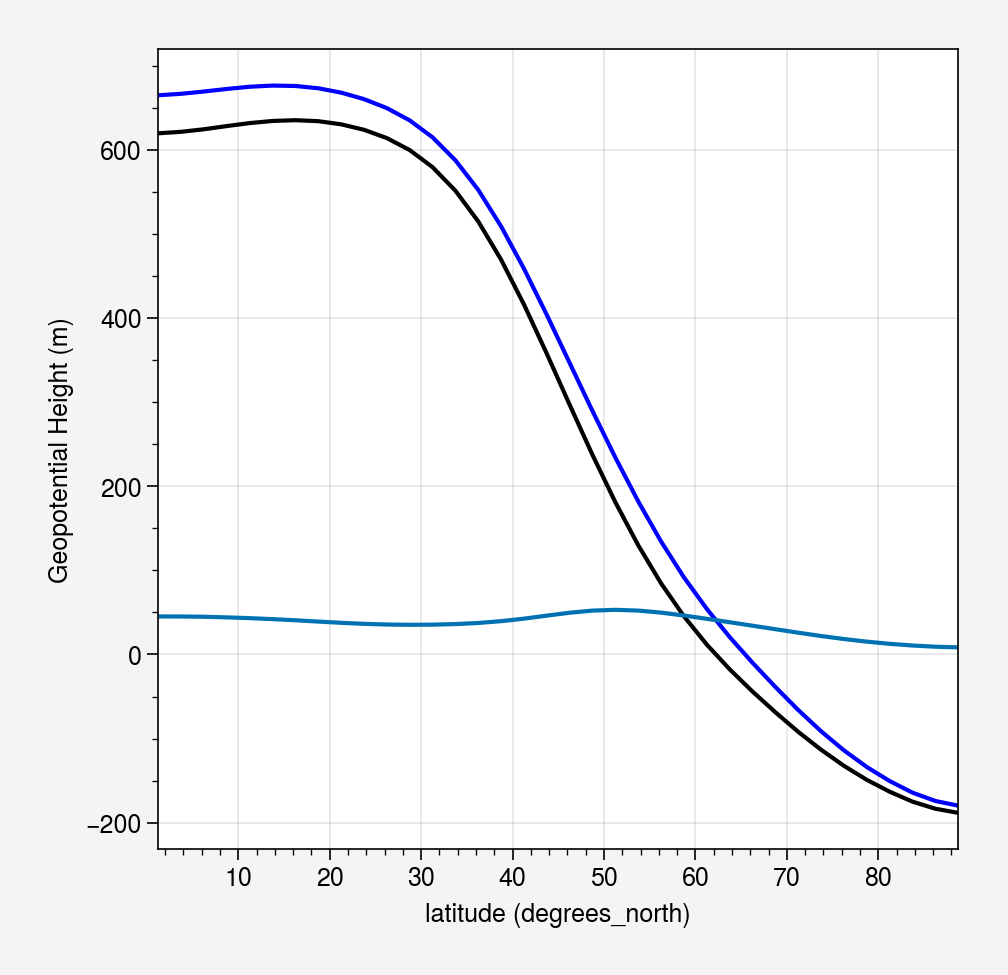

In [10]:
# 画图输出
fig = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.5, outerpad=2.0)
axs = fig.subplots(ncols=1, nrows=1)

axs.line(hgthis_lonmean_MME.loc[0:], color="black")
axs.line(hgtssp585_p3_lonmean_MME.loc[0:], color="blue")
axs.line((hgtssp585_p3_lonmean_MME - hgthis_lonmean_MME.loc[0:]))
print((hgtssp585_p3_lonmean_MME - hgthis_lonmean_MME.loc[0:]))

### 从上图中的结果看来，如果直接计算纬偏值，会将一部分由于不均匀增暖导致的hgt的经向梯度消磨掉（这种梯度在中高纬度尤其明显），因此，需要修正之前计算纬偏值的方式，改为计算eddy geopotential height
根据我们需要分析的区域，改为将0-55°N, 180°E-180°W的区域平均值减去，然后重新计算